In [ ]:
#NOTES

In [2]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

In [5]:
# Data download
# ==============================================================================
# url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
# data = pd.read_csv(url, sep=',')

# https://www.listendata.com/2019/06/pandas-read-csv.html#id-44f154
Data = pd.read_csv('Final Data with Features.csv')
Data['Date'] = pd.to_datetime(Data['Date'])
Data = Data.set_index('Date')
Data = Data[["VIX_Close","HSI_Close","Dollar_Close"]]
# y = Data.VIX_Close

The column `date` has been stored as a `string`. To convert it to `datetime` the `pd.to_datetime()` function can be use. Once in `datetime` format, and to make use of **Pandas** functionalities, it is set as an index. Also, since the data is monthly, the frequency is set as Monthly Started 'MS'.

In [11]:
data = Data
data

,VIX_Close,HSI_Close,Dollar_Close
Date,,,
1990-01-02,17.240000,2838.100098,94.290001
1990-01-03,18.190001,2858.699951,94.419998
1990-01-04,19.219999,2868.000000,92.519997
1990-01-05,20.110001,2839.899902,92.849998
1990-01-06,20.110001,2839.899902,92.849998
...,...,...,...
2022-10-29,25.750000,14863.059570,110.669998
2022-10-30,25.750000,14863.059570,110.669998
2022-10-31,25.879999,14687.019530,111.529999


In [15]:
# asfreq -- fill up time gaps
data = data.rename(columns={'VIX_Close': 'y','HSI_Close':'exog_1','Dollar_Close':'exog_2'})
data = data.asfreq(freq='MS')
data = data.sort_index()
data.head()

,y,exog_1,exog_2
Date,,,
1990-02-01,24.870001,2738.199951,92.160004
1990-03-01,21.900000,2933.100098,94.000000
1990-04-01,19.730000,2997.000000,93.690002
1990-05-01,18.430000,2945.000000,93.089996
1990-06-01,17.090000,3159.000000,92.959999


When setting a frequency with the `asfreq()` method, **Pandas** fills the gaps that may exist in the time series with the value of `Null` to ensure the indicated frequency. Therefore, it should be checked if missing values have appeared after this transformation.

In [16]:
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


Although it is unnecessary, since a frequency has been established, it is possible to verify that the time series is complete.

In [17]:
# Verify that a temporary index is complete
# ==============================================================================
(data.index == pd.date_range(start=data.index.min(),
                             end=data.index.max(),
                             freq=data.index.freq)).all()

True

In [18]:
# Fill gaps in a temporary index
# ==============================================================================
# data.asfreq(freq='30min', fill_value=np.nan)

In [58]:
#TRAINING GARCH
import datetime as dt
import sys
# import arch.data.sp500
import numpy as np
import pandas as pd
from arch import arch_model

# data = arch.data.sp500.load()
market = data["y"]
# ret = 100 * market.pct_change()[1:].dropna()
ret = market / 100
realized_vol = ret.rolling(5).std()
# am = arch_model(ret, vol="Garch", p=1, o=0, q=1, dist="Normal")
# res = am.fit(update_freq=5)

In [59]:
garch = arch_model(ret, mean='zero', vol='GARCH', p=1, o=0, q=1)\
        .fit(disp='off')
print(garch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.003
Vol Model:                      GARCH   Log-Likelihood:                90.2692
Distribution:                  Normal   AIC:                          -174.538
Method:            Maximum Likelihood   BIC:                          -162.609
                                        No. Observations:                  394
Date:                Sun, Nov 27 2022   Df Residuals:                      394
Time:                        23:59:51   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.9291e-03  1.179e-03      3.334  8.571e-04 [1.

C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00615. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [60]:
bic_garch = []

for p in range(1, 5):
    for q in range(1, 5):
        garch = arch_model(ret, mean='zero',vol='GARCH', p=p, o=0, q=q)\
                .fit(disp='off')
        bic_garch.append(garch.bic)
        if garch.bic == np.min(bic_garch):
            best_param = p, q
garch = arch_model(ret, mean='zero', vol='GARCH',
                   p=best_param[0], o=0, q=best_param[1])\
        .fit(disp='off')
print(garch.summary())
forecast = garch.forecast(start=split_date[0])
forecast_garch = forecast

C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00615. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00615. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleW

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.003
Vol Model:                      GARCH   Log-Likelihood:                90.2692
Distribution:                  Normal   AIC:                          -174.538
Method:            Maximum Likelihood   BIC:                          -162.609
                                        No. Observations:                  394
Date:                Sun, Nov 27 2022   Df Residuals:                      394
Time:                        23:59:52   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.9291e-03  1.179e-03      3.334  8.571e-04 [1.

C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00615. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00615. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleW

In [61]:
from sklearn.metrics import mean_squared_error as mse
rmse_garch = np.sqrt(mse(realized_vol[-n:] / 100,
                         np.sqrt(forecast_garch\
                         .variance.iloc[-len(split_date):] 
                         / 100)))
print('The RMSE value of GARCH model is {:.4f}'.format(rmse_garch))

The RMSE value of GARCH model is 0.0215


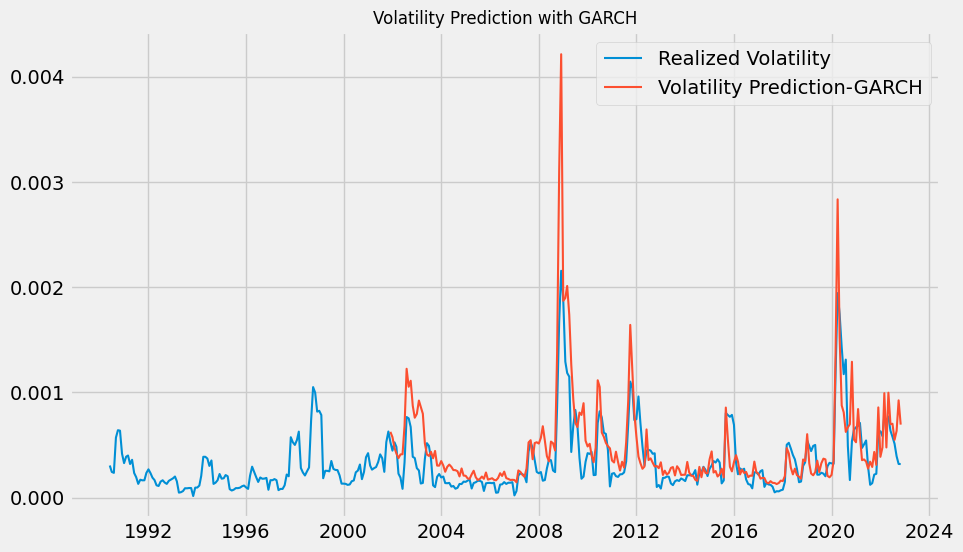

In [62]:
plt.figure(figsize=(10,6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_garch.variance.iloc[-len(split_date):] / 100, 
         label='Volatility Prediction-GARCH')
plt.title('Volatility Prediction with GARCH', fontsize=12)
plt.legend()
plt.show()

In [80]:
from arch.univariate import ARX, GARCH, ZeroMean, arch_model

burn = 250

x_mod = ARX(None, lags=1)
x0 = x_mod.simulate([1, 0.8, 1], nobs=1000 + burn).data
x1 = x_mod.simulate([2.5, 0.5, 1], nobs=1000 + burn).data

resid_mod = ZeroMean(volatility=GARCH())
resids = resid_mod.simulate([0.1, 0.1, 0.8], nobs=1000 + burn).data

phi1 = 0.7
phi0 = 3
y = 10 + resids.copy()
for i in range(1, y.shape[0]):
    y[i] = phi0 + phi1 * y[i - 1] + 2 * x0[i] - 2 * x1[i] + resids[i]

x0 = x0.iloc[-1000:]
x1 = x1.iloc[-1000:]
y = y.iloc[-1000:]
y.index = x0.index = x1.index = np.arange(1000)

In [86]:
len(data.exog_1)

394

In [87]:
x0 = data.exog_1[-300:]
x1 = data.exog_2[-300:]
y = data.y[-300:]

y.index = x0.index = x1.index = np.arange(300)

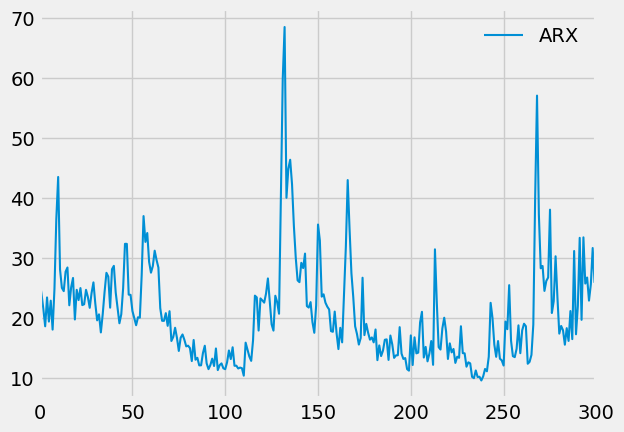

In [88]:
ax = pd.DataFrame({"ARX": y}).plot(legend=False)
ax.legend(frameon=False)
_ = ax.set_xlim(0, 300)

In [89]:
x0_oos = np.empty((300, 10))
x1_oos = np.empty((300, 10))
for i in range(10):
    if i == 0:
        last = x0
    else:
        last = x0_oos[:, i - 1]
    x0_oos[:, i] = 1 + 0.8 * last
    if i == 0:
        last = x1
    else:
        last = x1_oos[:, i - 1]
    x1_oos[:, i] = 2.5 + 0.5 * last

x1_oos[-1]

array([58.2400015 , 31.62000075, 18.31000038, 11.65500019,  8.32750009,
        6.66375005,  5.83187502,  5.41593751,  5.20796876,  5.10398438])

In [90]:
# Using Exogenous Variables
exog = pd.DataFrame({"x0": x0, "x1": x1})
mod = arch_model(y, x=exog, mean="ARX", lags=1)
res = mod.fit(disp="off")
print(res.summary())

                          AR-X - GARCH Model Results                          
Dep. Variable:                      y   R-squared:                       0.616
Mean Model:                      AR-X   Adj. R-squared:                  0.613
Vol Model:                      GARCH   Log-Likelihood:               -867.359
Distribution:                  Normal   AIC:                           1748.72
Method:            Maximum Likelihood   BIC:                           1774.62
                                        No. Observations:                  299
Date:                Mon, Nov 28 2022   Df Residuals:                      295
Time:                        00:11:53   Df Model:                            4
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const           3.3911      2.557      1.326      0.

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


<AxesSubplot:>

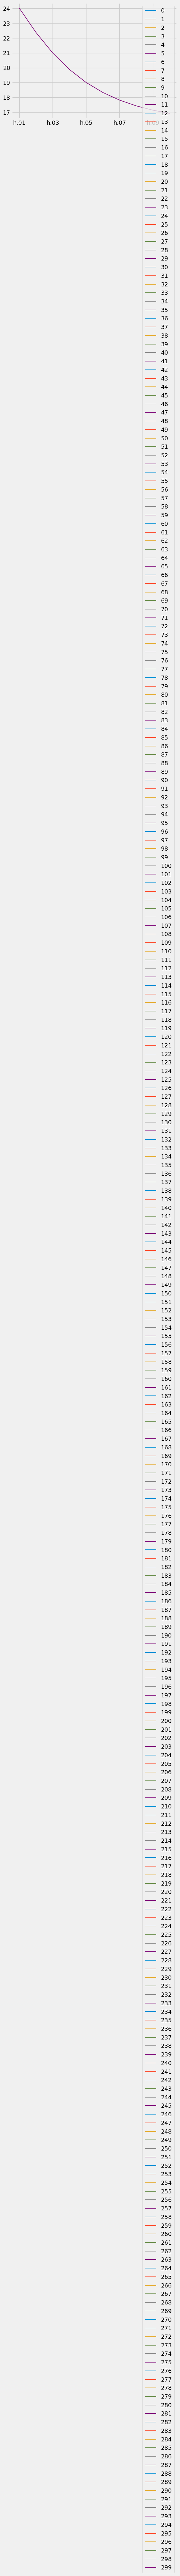

In [91]:
exog_fcast = {"x0": x0_oos[-1:], "x1": x1_oos[-1:]}
forecasts = res.forecast(horizon=10, x=exog_fcast)
forecasts.mean.T.plot()

In [95]:
res = mod.fit(disp="off", last_obs=150)
exog_fcast = {"x0": x0_oos[-150:], "x1": x1_oos[-150:]}
multi_forecasts = res.forecast(start=150, horizon=10, x=exog_fcast)
multi_forecasts.mean.tail(10)

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10
290,21.511000,20.680044,19.678190,18.624674,17.586978,16.602572,15.691063,14.861212,14.115124,13.450850
291,30.822740,28.312832,25.935119,23.754235,21.792780,20.051406,18.519543,17.181234,16.018348,15.012364
292,19.491214,18.933159,18.171301,17.328298,16.474606,15.650425,14.877918,14.168234,13.525696,12.950389
293,30.808935,28.231285,25.808564,23.600831,21.626241,19.881637,18.353391,17.023189,15.871139,14.877436
294,24.459956,23.003284,21.503639,20.055940,18.707115,17.477724,16.373678,15.392753,14.528300,13.771417
295,25.336989,23.758903,22.151198,20.608771,19.177704,17.877375,16.712427,15.679402,14.770505,13.975799
296,22.051955,20.967996,19.783938,18.603901,17.482151,16.445304,15.504375,14.661486,13.913709,13.255335
297,24.277434,22.784363,21.264299,19.809475,18.463564,17.244117,16.154562,15.190746,14.344595,13.606192
298,29.142208,26.687250,24.394354,22.319216,20.475710,18.857252,17.447802,16.227549,15.175840,14.272664
299,24.240612,22.557517,20.918982,19.397562,18.021877,16.798124,15.721284,14.781002,13.964716,13.259319


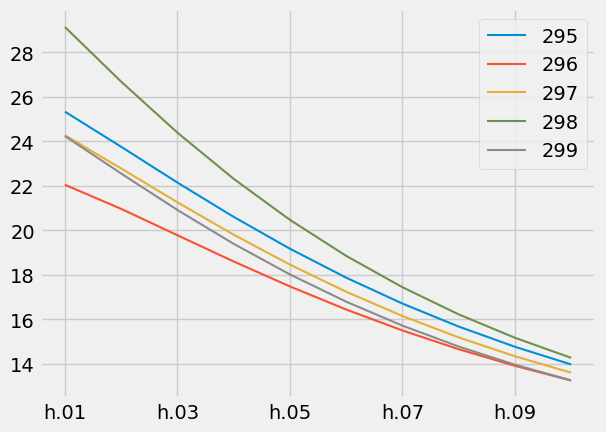

In [96]:
_ = multi_forecasts.mean.tail().T.plot()

The last 36 months are used as the test set to evaluate the predictive capacity of the model.

Train dates : 1990-02-01 00:00:00 --- 2019-11-01 00:00:00  (n=358)
Test dates  : 2019-12-01 00:00:00 --- 2022-11-01 00:00:00  (n=36)


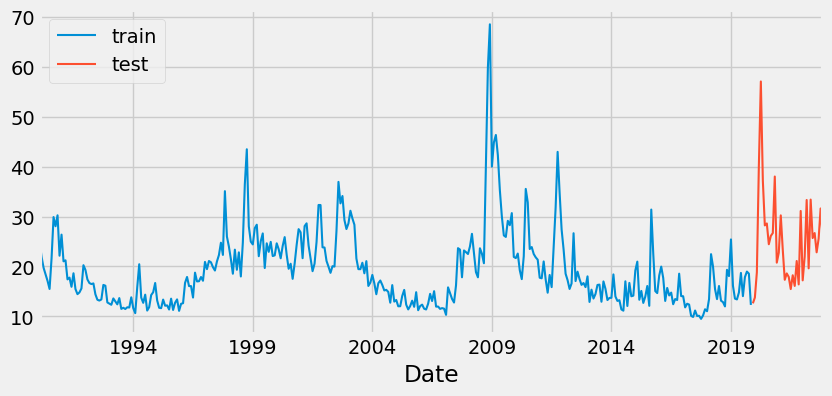

In [19]:
# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.legend();

### ForecasterAutoreg
<br>

With the `ForecasterAutoreg` class, a model is created and trained from a `RandomForestRegressor` regressor with a time window of 6 lags. This means that the model uses the previous 6 months as predictors.

In [20]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 6
             )

forecaster.fit(y=data_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1990-02-01 00:00:00'), Timestamp('2019-11-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-11-27 23:38:11 
Last fit date: 2022-11-27 23:38:11 
Skforecast version: 0.5.1 
Python version: 3.9.15 

### Predictions
<br>

Once the model is trained, the test data is predicted (36 months into the future).

In [21]:
# Predictions
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2019-12-01    17.4732
2020-01-01    17.0131
2020-02-01    18.3922
2020-03-01    15.1562
2020-04-01    15.2345
Freq: MS, Name: pred, dtype: float64

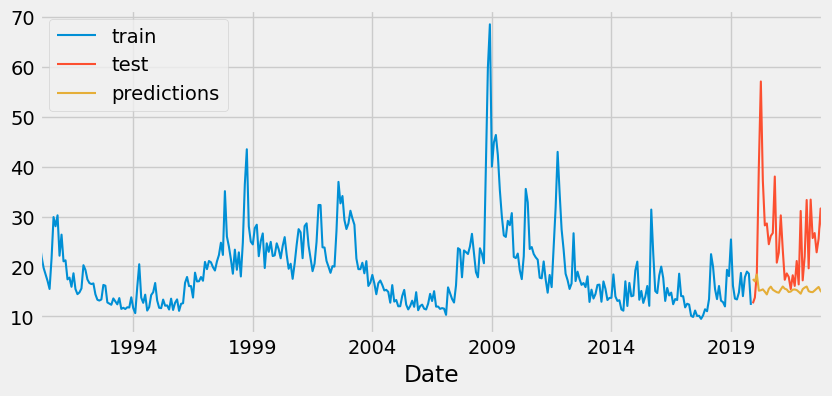

In [22]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

### Prediction error in the test set
<br>

The error that the model makes in its predictions is quantified. In this case, the metric used is the mean squared error (mse).

In [23]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 175.29676786930895


### Hyperparameter tuning
<br>

The trained `ForecasterAutoreg` uses a 6 lag time window and a [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) model with the default hyperparameters. However, there is no reason why these values are the most suitable. In order to identify the best combination of lags and hyperparameters, the **Skforecast** library provides the `grid_search_forecaster` function. It compares the results obtained with each model configuration.

For more detailed documentation, visit: [skforecast grid search forecaster](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/hyperparameter-tuning-and-lags-selection.html).

In [24]:
# Hyperparameter Grid search
# ==============================================================================
steps = 36
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [10, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 12.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:46<00:00, 23.00s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 55.44352576063895



In [25]:
# Grid Search results
# ==============================================================================
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",55.443526,3,500
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",55.575189,3,100
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",55.811256,3,500
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",55.983226,5,100
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",56.222311,3,100
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",56.497267,5,500
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 500}",57.617546,5,500
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",57.885035,5,100
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",58.225817,10,500
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",58.600599,10,100


The best results are obtained using a time window of 20 lags and a Random Forest set up of {'max_depth': 3, 'n_estimators': 500}.

### Final model
<br> 

Finally, a `ForecasterAutoreg` is trained with the optimal configuration found by validation. This step is not necessary if `return_best = True` is specified in the `grid_search_forecaster` function.

In [30]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )

forecaster.fit(y=data_train['y'])

In [31]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

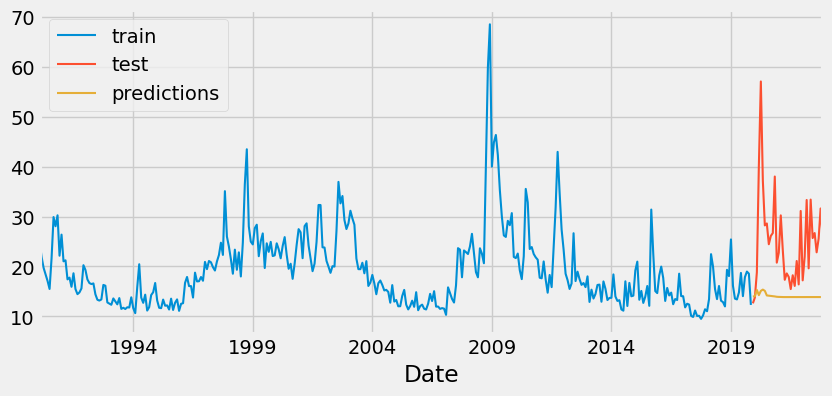

In [32]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [33]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 195.77255004113053


The optimal combination of hyperparameters significantly reduces test error.
<br><br>

### Backtesting

Backtesting is a term used in modeling to refer to testing a predictive model on historical data. Backtesting involves moving backward in time, step-by-step, in as many stages as is necessary. Therefore, it is a special type of cross-validation applied to previous period(s).

**Backtesting with refit and increasing training size (fixed origin)**

The model is trained each time before making predictions. With this configuration, the model uses all the data available so far. It is a variation of the standard cross-validation but, instead of making a random distribution of the observations, the training set increases sequentially, maintaining the temporal order of the data.

<img src="./images/diagram-backtesting-refit.png" style="width: 500px;"/>

<center><font size='2.5'> <i>Time series backtesting diagram with an initial training size of 10 observations, a prediction horizon of 3 steps, and retraining at each iteration.</i></font></center>

**Backtesting with refit and fixed training size (rolling origin)**

A technique similar to the previous one but, in this case, the forecast origin rolls forward, therefore, the size of training remains constant. This is also known as time series cross-validation or walk-forward validation.

<img src="./images/diagram-backtesting-refit-fixed-train-size.png" style="width: 500px;"/>

<center><font size='2.5'> <i>Time series backtesting diagram with an initial training size of 10 observations, a prediction horizon of 3 steps, and a training set of constant size.</i></font></center>

**Backtesting without refit**

After an initial train, the model is used sequentially without updating it and following the temporal order of the data. This strategy has the advantage of being much faster since the model is trained only once. However, the model does not incorporate the latest data available, so it may lose predictive capacity over time.

<img src="./images/diagram-backtesting-no-refit.png" style="width: 500px;"/>

<center><font size='2.5'> <i>Time series backtesting diagram with an initial training size of 10 observations, a prediction horizon of 3 steps, and no retraining at each iteration.</i></font></center>
<br>

The **skforecast** library has the mentioned [backtesting strategies](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/backtesting.html#backtesting) implemented. Regardless of which one is used, it is important not to include test data in the search process to avoid overfitting problems.

For this example, a **backtesting with refit** strategy is followed. Internally, the process that the function applies is:

+ In the first iteration, the model is trained with the observations selected for the initial training (in this case, 87). Then, the next 36 observations are used to validate the predictions of this first model.

+ In the second iteration, the model is retrained by adding, to the initial training set, the previous 36 validation observations (87 + 36). In the same way, the next 36 observations are established as the new validation set.

+ This process is repeated until all available observations are used. Following this strategy, the training set increases in each iteration with as many observations as steps are being predicted.

In [ ]:
# Backtesting
# ==============================================================================
steps = 36
n_backtesting = 36*3 # The last 9 years are separated for the backtest

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = data['y'],
                                    initial_train_size = len(data) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    metric             = 'mean_squared_error',
                                    refit              = True,
                                    verbose            = True
                                )

print(f"Backtest error: {metric}")

In [ ]:
fig, ax = plt.subplots(figsize=(9, 4))
data.loc[predictions_backtest.index, 'y'].plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend();

### Predictors importance
<br>

Since the `ForecasterAutoreg` object uses **Scikit-learn** models, the importance of predictors can be accessed once trained. When the regressor used is a `LinearRegression()`, `Lasso()` or `Ridge()`, the coefficients of the model reflect their importance. In `GradientBoostingRegressor()` or `RandomForestRegressor()` regressors, the importance of predictors is based on impurity.

*Note: the `get_feature_importance()` method only returns values if the regressor used within the forecaster has the attribute `coef_` or `feature_importances_`.*

In [ ]:
# Predictors importance
# ==============================================================================
forecaster.get_feature_importance()

## Recursive autoregressive forecasting with exogenous variables
<br>

In the previous example, only lags of the predicted variable itself have been used as predictors. In certain scenarios,  it is possible to have information about other variables, **whose future value is known**, so could serve as additional predictors in the model.

Continuing with the previous example, a new variable whose behavior is correlated with the modeled time series and it is wanted to incorporate as a predictor is simulated. The same applies to multiple exogenous variables.
<br><br>

### Data

In [ ]:
# Data download
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
data = pd.read_csv(url, sep=',')

# Data preparation
# ==============================================================================
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y/%m/%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.sort_index()

fig, ax = plt.subplots(figsize=(9, 4))
data['y'].plot(ax=ax, label='y')
data['exog_1'].plot(ax=ax, label='exogenous variable')
ax.legend();

In [ ]:
# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

### ForecasterAutoreg

In [ ]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 8
             )

forecaster.fit(y=data_train['y'], exog=data_train['exog_1'])
forecaster

### Predictions
<br>

If the `ForecasterAutoreg` is trained with an exogenous variable, the value of this variable must be passed to `predict()`. It is only applicable to scenarios in which future information on the exogenous variable is available.

In [ ]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps, exog=data_test['exog_1'])

In [ ]:
# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

### Prediction error in the test set

In [ ]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

### Hyperparameter tuning

In [ ]:
# Hyperparameter Grid search
# ==============================================================================
steps = 36
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

lags_grid = [5, 12, 20]

param_grid = {'n_estimators': [50, 100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                    forecaster  = forecaster,
                    y           = data_train['y'],
                    exog        = data_train['exog_1'],
                    param_grid  = param_grid,
                    lags_grid   = lags_grid,
                    steps       = steps,
                    refit       = True,
                    metric      = 'mean_squared_error',
                    initial_train_size = int(len(data_train)*0.5),
                    return_best = True,
                    verbose     = False
               )

In [ ]:
# Grid Search results
# ==============================================================================
results_grid.head()

The best results are obtained using a time window of 12 lags and a Random Forest set up of {'max_depth': 10, 'n_estimators': 50}.

### Final model
<br>

Setting `return_best = True` in `grid_search_forecaster`, after the search, the `ForecasterAutoreg` object has been modified and trained with the best configuration found.

In [ ]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps, exog=data_test['exog_1'])

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(y_true = data_test['y'], y_pred = predictions)
print(f"Test error (mse) {error_mse}")

## Recursive autoregressive forecasting with custom predictors
<br>

In addition to the lags, it may be interesting to incorporate other characteristics of the time series in some scenarios. For example, the moving average of the last *n* values could be used to capture the series's trend.

The `ForecasterAutoregCustom` class behaves very similar to the `ForecasterAutoreg` class seen in the previous sections, but with the difference that it is the user who defines the function used to create the predictors.

The first example of the document about predicting the last 36 months of the time series is repeated. In this case, the predictors are the first 10 lags and the values' moving average of the lasts 20 months.
<br><br>

### Data

In [ ]:
# Data download
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
data = pd.read_csv(url, sep=',')

# Data preparation
# ==============================================================================
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y/%m/%d')
data = data.set_index('date')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()

# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

### ForecasterAutoregCustom
<br>

A `ForecasterAutoregCustom` is created and trained from a `RandomForestRegressor` regressor. The `create_predictor()` function,  which calculates the first 10 lags and the moving average of the last 20 values, is used to create the predictors.

In [ ]:
# Function to calculate predictors from time series
# ==============================================================================
def custom_predictors(y):
    '''
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    '''
    
    lags = y[-1:-11:-1]
    mean = np.mean(y[-20:])
    predictors = np.hstack([lags, mean])
    
    return predictors

When creating the forecaster, the `window_size` argument must be equal to or greater than the window used by the function that creates the predictors. This value, in this case, is 20.

In [ ]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                regressor      = RandomForestRegressor(random_state=123),
                fun_predictors = custom_predictors,
                window_size    = 20
             )

forecaster.fit(y=data_train['y'])
forecaster

It is possible to access the custom function used to create the predictors.

In [ ]:
print(forecaster.source_code_create_predictors)

Using the method `create_train_X_y`, is it posible to acces the matrices that are created internally in the training process.

In [ ]:
X, y = forecaster.create_train_X_y(y=data_train['y'])
X.head(4)

In [ ]:
y.head(4)

### Predictions

In [ ]:
# Predictions
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps)

In [ ]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

### Prediction error in the test set

In [ ]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

### Hyperparameter tuning
<br>

When using the `grid_search_forecaster` function with a `ForecasterAutoregCustom`, the` lags_grid` argument is not specified.

In [ ]:
# Hyperparameter Grid search
# ==============================================================================
steps = 36
forecaster = ForecasterAutoregCustom(
                regressor      = RandomForestRegressor(random_state=123),
                fun_predictors = custom_predictors,
                window_size    = 20
             )

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                    forecaster  = forecaster,
                    y           = data_train['y'],
                    param_grid  = param_grid,
                    steps       = steps,
                    refit       = True,
                    metric      = 'mean_squared_error',
                    initial_train_size = int(len(data_train)*0.5),
                    fixed_train_size   = False,
                    return_best = True,
                    verbose     = False
               )

In [ ]:
# Grid Search results
# ==============================================================================
results_grid

### Final model

In [ ]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(y_true = data_test['y'], y_pred = predictions)
print(f"Test error (mse) {error_mse}")

## Direct multi-step forecasting
<br>

The `ForecasterAutoreg` and `ForecasterAutoregCustom` models follow a recursive prediction strategy in which each new prediction builds on the previous one. An alternative is to train a model for each of the steps to be predicted. This strategy, commonly known as direct multi-step forecasting, is computationally more expensive than recursive since it requires training several models. However, in some scenarios, it achieves better results. These kinds of models can be obtained with the `ForecasterAutoregDirect` class and can include one or multiple exogenous variables.
<br><br>

### ForecasterAutoregDirect
<br>

Unlike when using `ForecasterAutoreg` or `ForecasterAutoregCustom`, the number of steps to be predicted must be indicated in the `ForecasterAutoregDirect` type models. This means that the number of predictions obtained when executing the `predict()` method is always the same. It is not possible to predict steps beyond the value defined at their creation.

For this example, a linear model with `Lasso` penalty is used as a regressor. These models require the predictors to be standardized, so it is combined with a `StandardScaler`.

For more detailed documentation how to use transformers and pipelines, visit: [skforecast with scikit-learn and transformers pipelines](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/sklearn-transformers-and-pipeline.html).

In [ ]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                regressor     = Lasso(random_state=123),
                transformer_y = StandardScaler(),
                steps         = 36,
                lags          = 8
             )

forecaster

In [ ]:
# Hyperparameter Grid search
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                regressor     = Lasso(random_state=123),
                transformer_y = StandardScaler(),
                steps         = 36,
                lags          = 8 # This value will be replaced in the grid search
             )

# To access parameters of a scikitlearn pipeline the pattern:
# <name of the step>__<name of the parameter>.
param_grid = {'alpha': np.logspace(-5, 5, 10)}
lags_grid = [5, 12, 20]

results_grid = grid_search_forecaster(
                    forecaster         = forecaster,
                    y                  = data_train['y'],
                    param_grid         = param_grid,
                    lags_grid          = lags_grid,
                    steps              = 36,
                    refit              = True,
                    metric             = 'mean_squared_error',
                    initial_train_size = int(len(data_train)*0.5),
                    fixed_train_size   = False,
                    return_best        = True,
                    verbose            = False
                )

In [ ]:
# Grid Search results
# ==============================================================================
results_grid.head()

The best results are obtained using a time window of 12 lags and a Lasso setting {'alpha': 0.021544}.

In [ ]:
# Predictions
# ==============================================================================
predictions = forecaster.predict()

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(y_true = data_test['y'], y_pred = predictions)
print(f"Test error (mse) {error_mse}")

## Prediction intervals
<br>

A prediction interval defines the interval within which the true value of $y$ is expected to be found with a given probability.

Rob J Hyndman and George Athanasopoulos, list in their book *Forecasting: Principles and Practice* [multiple ways to estimate prediction intervals](https://otexts.com/fpp3/prediction-intervals.html), most of which require that the residuals (errors) of the model are distributed in a normal way. When this property cannot be assumed, bootstrapping can be resorted to, which only assumes that the residuals are uncorrelated. This is the method used in the **Skforecast** library for the `ForecasterAutoreg` and `ForecasterAutoregCustom` type models. For example, the prediction interval (1, 99) can be expected to contain the true prediction value with 98% probability.

<div>
<img src='./images/bootstrapped-prediction-interval.gif'/>
</div>

<center><font size='2.5'> <i>Diagram of how to create prediction intervals using bootstrapping.</i></font></center>

<br><br>

In [ ]:
# Data download
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
data_raw = pd.read_csv(url, sep=',')

# Data preparation
# ==============================================================================
data = data_raw.copy()
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y/%m/%d')
data = data.set_index('date')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()

# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

In [ ]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags = 15
             )

forecaster.fit(y=data_train['y'])

# Prediction intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                    steps    = steps,
                    interval = [1, 99],
                    n_boot   = 500
              )

predictions.head(5)

In [ ]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions.iloc[:, 0]
            )

print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_test['y'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='prediction')
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'red',
    alpha = 0.2
)
ax.legend();

In [ ]:
# Backtest with prediction intervals
# ==============================================================================
n_backtesting = 36*3 # The last 9 years are separated for backtesting
steps = 36
forecaster = ForecasterAutoreg(
                regressor = LinearRegression(),
                lags      = 15
             )

metric, predictions = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = data['y'],
                            initial_train_size = len(data) - n_backtesting,
                            fixed_train_size   = False,
                            steps              = steps,
                            metric             = 'mean_squared_error',
                            refit              = True,
                            interval           = [1, 99],
                            n_boot             = 100,
                            verbose            = True
                      )

print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data.loc[predictions.index, 'y'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predicciones')
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'red',
    alpha = 0.2
)
ax.legend();

In [ ]:
# Predicted interval coverage
# ==============================================================================
inside_interval = np.where(
                     (data.loc[predictions.index, 'y'] >= predictions['lower_bound']) & \
                     (data.loc[predictions.index, 'y'] <= predictions['upper_bound']),
                     True,
                     False
                   )

coverage = inside_interval.mean()
print(f"Predicted interval coverage: {round(100*coverage, 2)} %")

## Custom metric
<br>

In the backtesting (`backtesting_forecaster`) and hyperparameter optimization (`grid_search_forecaster`) processes, besides the frequently used metrics: mean_squared_error, mean_absolute_error, and mean_absolute_percentage_error, it is possible to use any custom function as long as:

+ It includes the arguments:

    + `y_true`: true values of the series.

    + `y_pred`: predicted values.

+ It returns a numeric value (`float` or `int`).

+ The metric is reduced as the model improves. Only applies in the `grid_search_forecaster` function if `return_best=True` (train the forecaster with the best model).

It allows evaluating the predictive capability of the model in a wide range of scenarios, for example:

+ Consider only certain months, days, hours...

+ Consider only dates that are holidays.

+ Consider only the last step of the predicted horizon.

The following example shows how to forecast a 12-month horizon but considering only the last 3 months of each year to calculate the interest metric.

In [ ]:
# Custom metric 
# ==============================================================================
from sklearn.metrics import mean_absolute_error

def custom_metric(y_true, y_pred):
    '''
    Calculate the mean squared error using only the predicted values of the last
    3 months of the year.
    '''
    mask = y_true.index.month.isin([10, 11, 12])
    metric = mean_absolute_error(y_true[mask], y_pred[mask])
    
    return metric

In [ ]:
# Backtesting 
# ==============================================================================
steps = 36
n_backtesting = 36*3 # The last 9 years are separated for backtesting

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = data['y'],
                                    initial_train_size = len(data) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    refit              = True,
                                    metric             = custom_metric,
                                    verbose            = True
                               )

print(f"Backtest error: {metric}")

## Save and load models
<br>

Skforecast models can be stored and loaded from disck using pickle or joblib library. To simply the process, two functions are available: `save_forecaster` and `load_forecaster`,  simple example is shown below. For more detailed documentation, visit: [skforecast save and load forecaster](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/save-load-forecaster.html).

In [ ]:
# Create forecaster
forecaster = ForecasterAutoreg(RandomForestRegressor(random_state=123), lags=3)
forecaster.fit(y=data['y'])
forecaster.predict(steps=3)

In [ ]:
# Save model
save_forecaster(forecaster, file_name='forecaster.py', verbose=False)

In [ ]:
# Load model
forecaster_loaded = load_forecaster('forecaster.py')

In [ ]:
# Predict
forecaster_loaded.predict(steps=3)

## Use forecaster in production
<br>

In projects related to forecasting, it is common to generate a model after the experimentation and development phase. For this model to have a positive impact on the business, it must be able to be put into production and generate forecasts from time to time with which to decide. This need has widely guided the development of the **Skforecast** library.

Suppose predictions have to be generated on a weekly basis, for example, every Monday. By default, when using the `predict` method on a trained forecaster object, predictions start right after the last training observation. Therefore, the model could be retrained weekly, just before the first prediction is needed, and call its `predict` method.

This strategy, although simple, may not be possible to use for several reasons:

+ Model training is very expensive and cannot be run as often.

+ The history with which the model was trained is no longer available.

+ The prediction frequency is so high that there is no time to train the model between predictions.

In these scenarios, the model must be able to predict at any time, even if it has not been recently trained.

Every model generated using **Skforecast** has the `last_window` argument in its `predict` method. Using this argument, it is possible to provide only the past values needs to create the autoregressive predictors (lags) and thus, generate the predictions without the need to retrain the model.

For more detailed documentation, visit: [skforecast forecaster in production](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/forecaster-in-production.html).

In [ ]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
             )

forecaster.fit(y=data_train['y'])

Since the model uses the last 6 lags as predictors, `last_window` must contain at least the 6 values previous to the moment where the prediction starts.

In [ ]:
last_window = data_test['y'][-6:]
forecaster.predict(last_window=last_window, steps=4)

If the forecaster uses exogenous variables, besides `last_window`, the argument `exog` must contain the future values of the exogenous variables.

## Session information

In [ ]:
import session_info
session_info.show(html=False)

## Bibliography
<br>

Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia. [Book](https://otexts.com/fpp3/)

Time Series Analysis and Forecasting with ADAM Ivan Svetunkov [Book](https://openforecast.org/adam/)

Python Data Science Handbook by Jake VanderPlas [Book](https://www.amazon.es/gp/product/1491912057/ref=as_li_qf_asin_il_tl?ie=UTF8&tag=cienciadedato-21&creative=24630&linkCode=as2&creativeASIN=1491912057&linkId=73620d22f9d4a0a76d27592dabf13c83)

Python for Finance: Mastering Data-Driven Finance [Book](https://www.amazon.es/gp/product/1492024333/ref=as_li_qf_asin_il_tl?ie=UTF8&tag=cienciadedato-21&creative=24630&linkCode=as2&creativeASIN=1492024333&linkId=70c3175ad015970cd1c2328b7a40a055)

**How to cite this document?**

<p style="text-align:left"><font size="3" color="#555">
Skforecast: time series forecasting with Python and Scikit-learn by Joaquín Amat Rodrigo and Javier Escobar Ortiz, available under a Attribution 4.0 International (CC BY 4.0) at https://www.cienciadedatos.net/py27-forecasting-series-temporales-python-scikitlearn.html
    
</font></p>

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work by  Joaquín Amat Rodrigo is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.